In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import praw # Python Reddit API Wrapper

Day Index Daily Return Index Level 2x LETF Daily Return 2x LETF Level
 D1            +25.00%      125.00              +50.00%        150.00
 D2            -20.00%      100.00              -40.00%         90.00
 D3            +25.00%      125.00              +50.00%        135.00
 D4            -20.00%      100.00              -40.00%         81.00
End                         100.00                              81.00


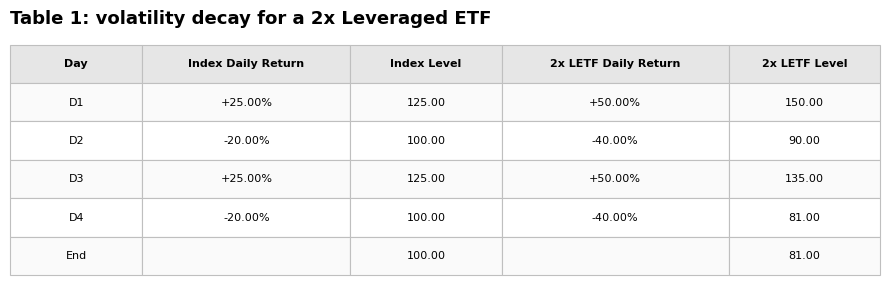

In [3]:
# Volatility Decay Table Figure (publication quality)
# This script creates a clean, print-ready table illustrating how a regular ETF
# (1x) can end at ~100 while a daily rebalanced leveraged ETF (e.g., 2x) ends below 100
# in a volatile, sideways market. It saves both PNG and SVG versions.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table

# ---------- Parameters (you can tweak these) ----------
start_price = 100.0
leverage = 2.0           # You can change to 3.0, etc.
up_return = 0.25         # +20% up day
pairs = 2                # Number of up/down pairs (total days = 2 * pairs)

# Compute the matching down return so that the index ends unchanged over each two-day pair:
down_return = (1.0 / (1.0 + up_return)) - 1.0

# Build the series of daily returns that oscillate up/down
daily_returns_index = []
for i in range(pairs):
    daily_returns_index.append(up_return)
    daily_returns_index.append(down_return)

days = len(daily_returns_index)

# ---------- Simulate index (1x), regular ETF (tracks index), and a daily rebalanced LETF ----------
index_levels = [start_price]
etf1x_levels = [start_price]
letf_levels = [start_price]

# For LETF, apply 'leverage * daily_return' each day (bounded only by math, no borrowing/fees modeled)
for r in daily_returns_index:
    # Index (and 1x ETF) move by r
    new_index = index_levels[-1] * (1.0 + r)
    index_levels.append(new_index)
    etf1x_levels.append(new_index)

    # Leveraged ETF rebalanced daily: compounds (1 + L*r)
    letf_levels.append(letf_levels[-1] * (1.0 + leverage * r))

# ---------- Build DataFrame ----------
def pct_fmt(x):
    return f"{x:+.2%}"

def price_fmt(x):
    return f"{x:,.2f}"

df = pd.DataFrame({
    "Day": [f"D{i+1}" for i in range(days)],
    "Index Daily Return": list(map(pct_fmt, daily_returns_index)),
    "Index Level": list(map(price_fmt, index_levels[1:])),
    f"{int(leverage)}x LETF Daily Return": list(map(pct_fmt, (leverage * np.array(daily_returns_index)))),
    f"{int(leverage)}x LETF Level": list(map(price_fmt, letf_levels[1:])),
})

# Add a summary/end row
end_index = index_levels[-1]
end_letf = letf_levels[-1]

summary = pd.DataFrame({
    "Day": ["End"],
    "Index Daily Return": [""],
    "Index Level": [price_fmt(end_index)],
    f"{int(leverage)}x LETF Daily Return": [""],
    f"{int(leverage)}x LETF Level": [price_fmt(end_letf)],
})

df_final = pd.concat([df, summary], ignore_index=True)

# ---------- Create a publication-quality table figure ----------
# Style parameters chosen to be print-friendly and minimalistic
fig_width = 9.0   # inches
fig_height = 0.5 + 0.35 * (len(df_final) + 2)  # scale with rows

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.axis('off')

# Title and subtitle/caption
title = f"Table 1: volatility decay for a {int(leverage)}x Leveraged ETF"
subtitle = (
    f"Path: alternating +{up_return:.1%} and {down_return:.2%} returns; "
    f"Start = {price_fmt(start_price)}, End(Index) = {price_fmt(end_index)}, "
    f"End({int(leverage)}x LETF) = {price_fmt(end_letf)}"
)

# Render text headers
ax.text(0.0, 1.02, title, fontsize=13, fontweight='bold', va='bottom', ha='left', transform=ax.transAxes)

# Build table
table = Table(ax, bbox=[0, 0, 1, 0.95])

# Column labels
columns = df_final.columns.tolist()
n_rows, n_cols = df_final.shape
row_height = 1.0 / (n_rows + 1)  # +1 for header
col_widths = [0.14, 0.22, 0.16, 0.24, 0.16]

# Header
for j, col in enumerate(columns):
    table.add_cell(row=0, col=j, text=col, loc='center', width=col_widths[j], height=row_height, facecolor='0.9')
    cell = table[(0, j)]
    cell.set_text_props(fontweight='bold', fontsize=13)

# Body cells
for i in range(n_rows):
    for j in range(n_cols):
        val = df_final.iat[i, j]
        fc = '0.98' if i % 2 == 0 else '1.0'  # subtle zebra striping
        table.add_cell(row=i+1, col=j, text=val, loc='center', width=col_widths[j], height=row_height, facecolor=fc)
        cell = table[(i+1, j)]
        cell.set_text_props(fontsize=13)

# Add outer box and column separators
for i in range(n_rows + 1):
    for j in range(n_cols):
        cell = table[(i, j)]
        cell.set_edgecolor('0.75')
        cell.set_linewidth(0.8)

ax.add_table(table)

# Footnote
footnote = (
    "Note: The index path is constructed so that over each up/down pair, the index returns to its prior level, "
    "yet the daily rebalanced LETF compounds (1 + L·r) leading to erosion in sideways volatility."
)
#ax.text(0.0, -0.02, footnote, fontsize=9, va='top', ha='left', transform=ax.transAxes, wrap=True)

plt.tight_layout()

# Save high-resolution outputs
plt.savefig("volatility_decay_table.png", dpi=300, bbox_inches='tight')
plt.savefig("volatility_decay_table.svg", bbox_inches='tight')

print(df_final.to_string(index=False))


Table saved successfully!

Day Daily Return Index Level 2x Daily Return 2x Leveraged ETF Level
 D1       +25.0%      125.00          +50.0%                 150.00
 D2       -20.0%      100.00          -40.0%                  90.00
 D3       +25.0%      125.00          +50.0%                 135.00
 D4       -20.0%      100.00          -40.0%                  81.00
End            —      100.00               —                  81.00


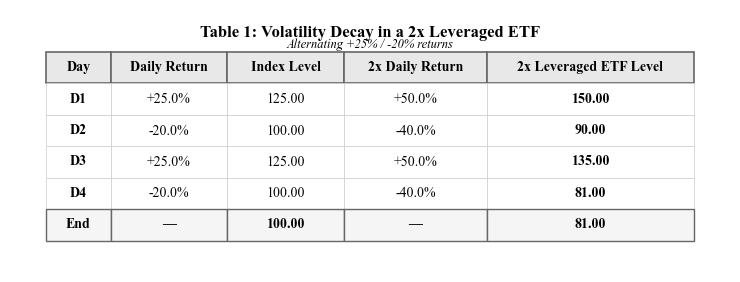

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Set Times New Roman as default font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# ---------- Parameters ----------
start_price = 100.0
leverage = 2.0
up_return = 0.25
pairs = 2

# Compute matching down return
down_return = (1.0 / (1.0 + up_return)) - 1.0

# Build daily returns
daily_returns_index = []
for i in range(pairs):
    daily_returns_index.append(up_return)
    daily_returns_index.append(down_return)

days = len(daily_returns_index)

# ---------- Simulate levels ----------
index_levels = [start_price]
letf_levels = [start_price]

for r in daily_returns_index:
    index_levels.append(index_levels[-1] * (1.0 + r))
    letf_levels.append(letf_levels[-1] * (1.0 + leverage * r))

# ---------- Build DataFrame ----------
def pct_fmt(x):
    return f"{x:+.1%}"

def price_fmt(x):
    return f"{x:.2f}"

df = pd.DataFrame({
    "Day": [f"D{i+1}" for i in range(days)],
    "Daily Return": list(map(pct_fmt, daily_returns_index)),
    "Index Level": list(map(price_fmt, index_levels[1:])),
    "2x Daily Return": list(map(pct_fmt, (leverage * np.array(daily_returns_index)))),
    "2x Leveraged ETF Level": list(map(price_fmt, letf_levels[1:])),
})

# Add end row
summary = pd.DataFrame({
    "Day": ["End"],
    "Daily Return": ["—"],
    "Index Level": [price_fmt(index_levels[-1])],
    "2x Daily Return": ["—"],
    "2x Leveraged ETF Level": [price_fmt(letf_levels[-1])],
})

df_final = pd.concat([df, summary], ignore_index=True)

# ---------- Create figure ----------
fig_width = 7.5
row_height_inch = 0.32
n_rows = len(df_final) + 1  # +1 for header
fig_height = row_height_inch * n_rows + 1.0  # extra for title

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.axis('off')

# Title
title = f"Table 1: Volatility Decay in a {int(leverage)}x Leveraged ETF"
ax.text(0.5, 0.94, title, fontsize=12, fontweight='bold', 
        va='top', ha='center', transform=ax.transAxes)

# Subtitle
subtitle = f"Alternating +{up_return:.0%} / {down_return:.0%} returns"
ax.text(0.5, 0.89, subtitle, fontsize=9, style='italic',
        va='top', ha='center', transform=ax.transAxes)

# Build table
table = Table(ax, bbox=[0.05, 0.12, 0.9, 0.72])

columns = df_final.columns.tolist()
n_rows_data, n_cols = df_final.shape
row_height = 1.0 / (n_rows_data + 1)
col_widths = [0.10, 0.18, 0.18, 0.22, 0.32]

# Header row
for j, col in enumerate(columns):
    cell = table.add_cell(0, j, col_widths[j], row_height, 
                          text=col, loc='center', facecolor='#E8E8E8')
    cell.set_text_props(fontweight='bold', fontsize=10)
    cell.set_edgecolor('#666666')
    cell.set_linewidth(1.0)

# Data rows
for i in range(n_rows_data):
    is_end_row = (i == n_rows_data - 1)
    
    for j in range(n_cols):
        val = df_final.iat[i, j]
        
        # Styling
        if is_end_row:
            fc = '#F5F5F5'
            fw = 'bold'
        else:
            fc = 'white'
            fw = 'normal'
        
        # Make first and last columns bold
        if j == 0 or j == n_cols - 1:
            fw = 'bold'
        
        cell = table.add_cell(i+1, j, col_widths[j], row_height,
                             text=val, loc='center', facecolor=fc)
        cell.set_text_props(fontsize=10, fontweight=fw)
        cell.set_edgecolor('#CCCCCC')
        cell.set_linewidth(0.5)
        
        # Bold border for end row
        if is_end_row:
            cell.set_edgecolor('#666666')
            cell.set_linewidth(1.0)

# Thicker top border for header
for j in range(n_cols):
    cell = table[(0, j)]
    cell.set_linewidth(1.2)

ax.add_table(table)

plt.tight_layout()

# Save outputs
plt.savefig("volatility_decay_table.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig("volatility_decay_table.pdf", bbox_inches='tight', facecolor='white')
plt.savefig("volatility_decay_table.svg", bbox_inches='tight', facecolor='white')

print("Table saved successfully!")
print("\n" + df_final.to_string(index=False))